In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [54]:
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [3]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
combine = [train_df, test_df]

Data Columns

Both train.csv and test.csv contain the following features:

    PassengerId: Unique identifier for each passenger.
    Survived: Target variable (0 = No, 1 = Yes) [Only in train.csv].
    Pclass: Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd).
    Name: Passenger's name.
    Sex: Gender of the passenger.
    Age: Age of the passenger in years.
    SibSp: Number of siblings/spouses aboard.
    Parch: Number of parents/children aboard.
    Ticket: Ticket number.
    Fare: Passenger fare.
    Cabin: Cabin number.
    Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Exploratory Data Analysis (EDA)

**Survival Counts:**

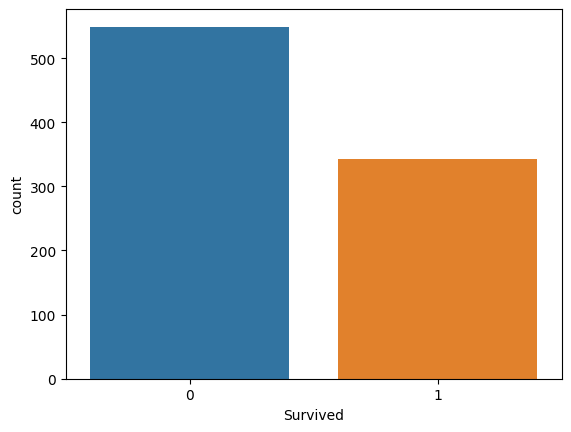

In [11]:
sns.countplot(x='Survived', data=train_df)
plt.show()

**Survival by Sex:**

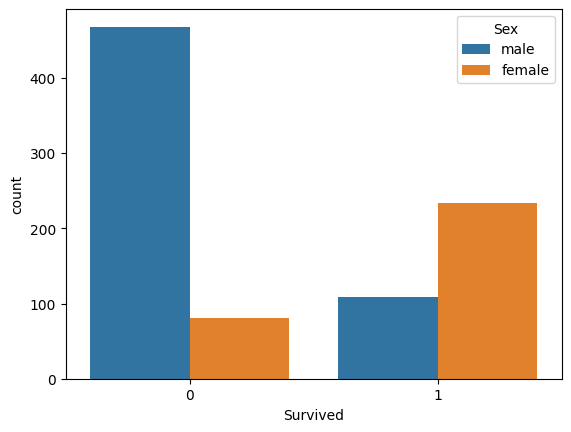

In [12]:
sns.countplot(x='Survived', hue='Sex', data=train_df)
plt.show()


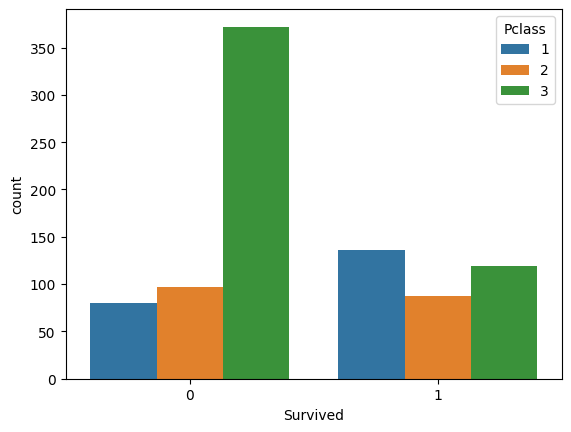

In [13]:
sns.countplot(x='Survived', hue='Pclass', data=train_df)
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


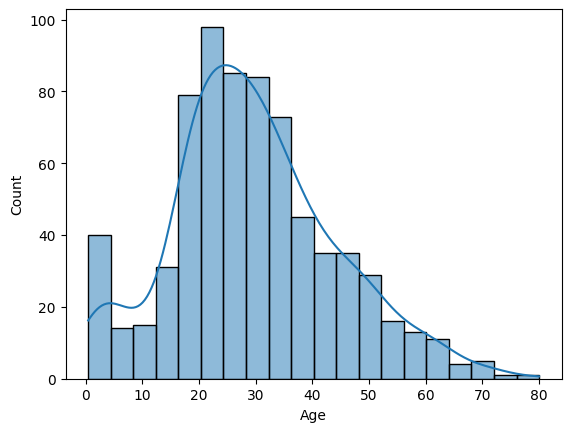

In [14]:
sns.histplot(train_df['Age'].dropna(), kde=True)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


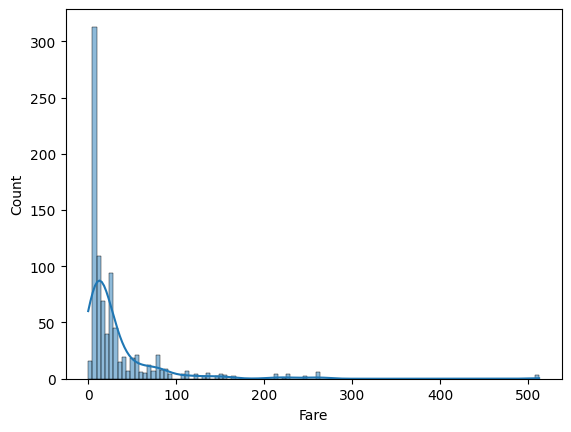

In [15]:
sns.histplot(train_df['Fare'], kde=True)
plt.show()

## Data Cleaning and Preprocessing

In [19]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

/tmp/ipykernel_37/2703274470.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
/tmp/ipykernel_37/2703274470.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [20]:
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [21]:
train_df['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [22]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

/tmp/ipykernel_37/3321481184.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)


In [23]:
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

/tmp/ipykernel_37/4271572204.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)


In [24]:
train_df.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)
test_ids = test_df['PassengerId']
test_df.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

In [26]:
import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in [train_df, test_df]:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Simplify titles
for dataset in [train_df, test_df]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df.drop('Name', axis=1, inplace=True)



KeyError: 'Name'

In [27]:
test_df.drop('Name', axis=1, inplace=True)


In [28]:
for dataset in [train_df, test_df]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1


In [29]:
for dataset in [train_df, test_df]:
    dataset['IsAlone'] = 1
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0


In [30]:
train_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)


In [32]:
for dataset in [train_df, test_df]:
    dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=[0, 12, 20, 40, 120], labels=['Child', 'Teenager', 'Adult', 'Elder'])



In [33]:
train_df.drop('Age', axis=1, inplace=True)
test_df.drop('Age', axis=1, inplace=True)

In [34]:
for dataset in [train_df, test_df]:
    dataset['FareBand'] = pd.qcut(dataset['Fare'], 4, labels=[1, 2, 3, 4])
train_df.drop('Fare', axis=1, inplace=True)
test_df.drop('Fare', axis=1, inplace=True)


In [36]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for dataset in [train_df, test_df]:
    dataset['Sex'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked'] = label.fit_transform(dataset['Embarked'])
    dataset['Title'] = label.fit_transform(dataset['Title'])
    dataset['AgeGroup'] = label.fit_transform(dataset['AgeGroup'])


In [38]:
train_df = pd.get_dummies(train_df, columns=['Title',  'AgeGroup'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Title',  'AgeGroup'], drop_first=True)


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_features = ['FareBand', 'FamilySize']
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])


In [40]:
train_df

,Survived,Pclass,Sex,Embarked,FamilySize,IsAlone,FareBand,Title_1,Title_2,Title_3,Title_4,AgeGroup_1,AgeGroup_2,AgeGroup_3
0,0,3,1,2,0.059160,0,-1.339737,False,True,False,False,False,False,False
1,1,1,0,0,0.059160,0,1.344758,False,False,True,False,False,False,False
2,1,3,0,2,-0.560975,1,-0.444905,True,False,False,False,False,False,False
3,1,1,0,2,0.059160,0,1.344758,False,False,True,False,False,False,False
4,0,3,1,2,-0.560975,1,-0.444905,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,2,-0.560975,1,-0.444905,False,False,False,True,False,False,False
887,1,1,0,2,-0.560975,1,0.449927,True,False,False,False,False,False,True
888,0,3,0,2,1.299429,0,0.449927,True,False,False,False,False,False,False
889,1,1,1,0,-0.560975,1,0.449927,False,True,False,False,False,False,False


In [41]:
test_df

,Pclass,Sex,Embarked,FamilySize,IsAlone,FareBand,Title_1,Title_2,Title_3,Title_4,AgeGroup_1,AgeGroup_2,AgeGroup_3
0,3,1,1,-0.560975,1,-1.339737,False,True,False,False,False,False,False
1,3,0,2,0.059160,0,-1.339737,False,False,True,False,False,True,False
2,2,1,1,-0.560975,1,-0.444905,False,True,False,False,False,True,False
3,3,1,2,-0.560975,1,-0.444905,False,True,False,False,False,False,False
4,3,0,2,0.679295,0,-0.444905,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,2,-0.560975,1,-0.444905,False,True,False,False,False,False,False
414,1,0,0,-0.560975,1,1.344758,False,False,False,True,False,False,False
415,3,1,2,-0.560975,1,-1.339737,False,True,False,False,False,False,False
416,3,1,2,-0.560975,1,-0.444905,False,True,False,False,False,False,False


In [42]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_test = test_df.copy()


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
# Define the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the model with the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print('Best parameters found by GridSearch:', best_params)

# Train the final model with the best parameters
final_model = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    use_label_encoder=False,
    eval_metric='logloss'
)

final_model.fit(X_train, y_train)

# Make predictions and evaluate accuracy
y_pred_xgb = final_model.predict(X_val)
print('XGBoost Accuracy:', accuracy_score(y_val, y_pred_xgb))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found by GridSearch: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
XGBoost Accuracy: 0.8212290502793296


In [56]:
from sklearn.metrics import accuracy_score


print('XGBoost Accuracy:', accuracy_score(y_val, y_pred_xgb))


XGBoost Accuracy: 0.8212290502793296


In [57]:
from sklearn.metrics import confusion_matrix, classification_report

print('XGBoost Classification Report:\n', classification_report(y_val, y_pred_xgb))
print('XGBoost Confusion Matrix:\n', confusion_matrix(y_val, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

XGBoost Confusion Matrix:
 [[92 13]
 [19 55]]


In [62]:
test_ids


0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [63]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best Trial:', study.best_trial.params)

[I 2024-09-21 13:02:22,834] A new study created in memory with name: no-name-1db15cea-5d52-4504-9cd7-5b32ef3826ef
[I 2024-09-21 13:02:24,475] Trial 0 finished with value: 0.7977149610952428 and parameters: {'n_estimators': 557, 'max_depth': 11, 'learning_rate': 0.26615564132657615, 'subsample': 0.6591365803709852}. Best is trial 0 with value: 0.7977149610952428.
[I 2024-09-21 13:02:25,612] Trial 1 finished with value: 0.8187826258248794 and parameters: {'n_estimators': 341, 'max_depth': 19, 'learning_rate': 0.07796867719080233, 'subsample': 0.5919733889643135}. Best is trial 1 with value: 0.8187826258248794.
[I 2024-09-21 13:02:26,315] Trial 2 finished with value: 0.8005121638924455 and parameters: {'n_estimators': 211, 'max_depth': 18, 'learning_rate': 0.28302736356020086, 'subsample': 0.6035761749493789}. Best is trial 1 with value: 0.8187826258248794.
[I 2024-09-21 13:02:27,721] Trial 3 finished with value: 0.8019501625135428 and parameters: {'n_estimators': 413, 'max_depth': 16, 'l

Best Trial: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.011891590574661472, 'subsample': 0.7168162903499959}


In [65]:
predictions = final_model.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Survived': predictions
})

submission.to_csv('titanic_submission.csv', index=False)
